In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import scvi
import scanpy as sc
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import os
import torch
import sys
from datetime import datetime
import scarches as sca
from scipy.io import mmread

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/dask/array/chunk_types.py:110: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  import cupy
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'p

In [3]:
scvi.settings.progress_bar_style = "tqdm"
sc.set_figure_params(figsize=(4, 4), dpi=100, dpi_save=300)

nCores = 8
sc.settings.n_jobs = nCores
scvi.settings.num_threads = nCores

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    scvi.settings.seed = seed
    os.environ["PYTHONHASHSEED"] = str(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(123)

output_dir = "nba_integration/"
os.makedirs(output_dir, exist_ok=True)
output_tables = os.path.join(output_dir, "tables")
os.makedirs(output_tables, exist_ok=True)
output_figures = os.path.join(output_dir, "figures")
os.makedirs(output_figures, exist_ok=True)
sc.settings.figdir = output_figures

my_colors = [
    "#6495EDFF", "#FF69B4FF", "#BA55D3FF", "#F08080FF", "#32CD32FF",  
    "#9ACD32FF", "#4682B4FF", "#DDA0DDFF", "#FFA07AFF", "#8FBC8BFF",
    "#40E0D0FF", "#F0E68CFF", "#5F9EA0FF", "#D2B48CFF",  
    "#FFDAB9FF", "#87CEEBFF", "#B4A0E5", "#5BC0BE", "#773344", "#A4BEF3"
]

Seed set to 123


In [4]:
query = sc.read_h5ad("nba_integration/ATLAS_deepannotated.h5ad")

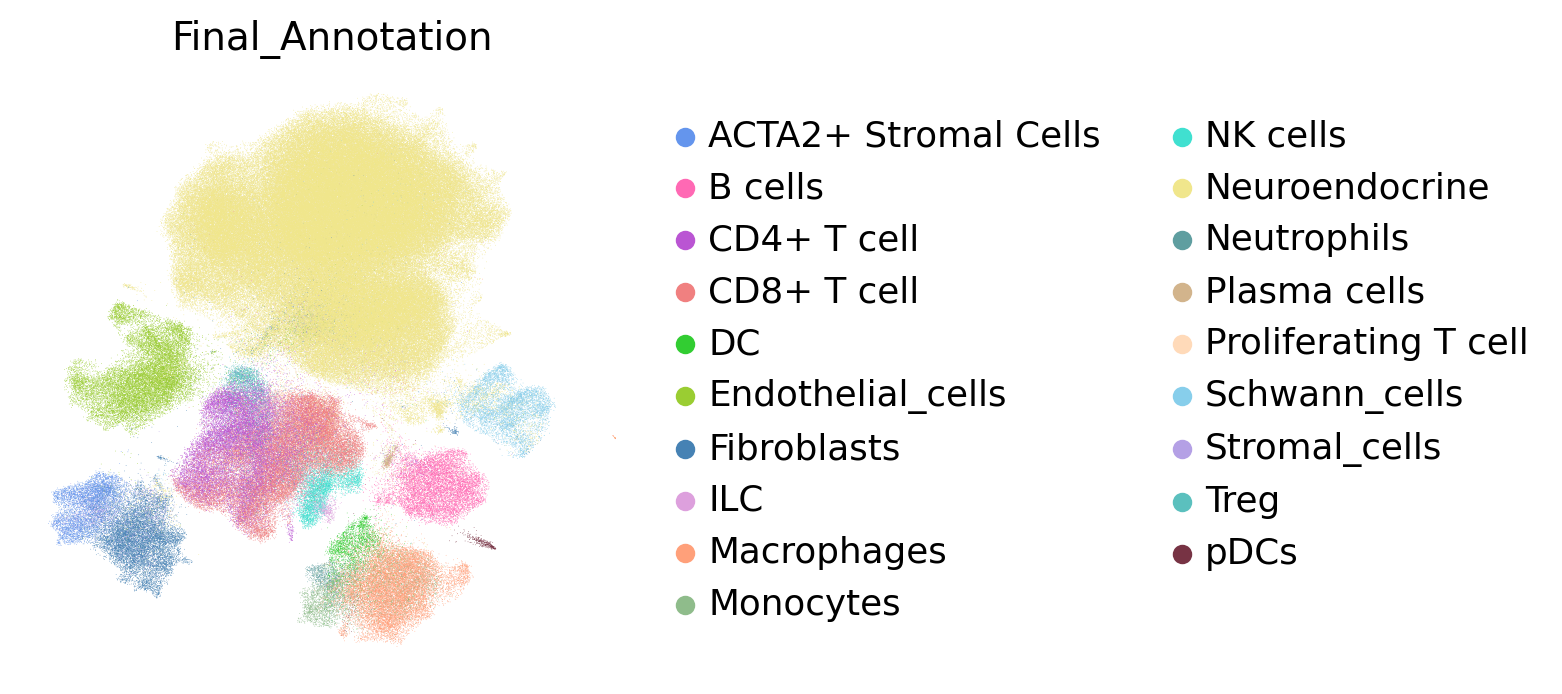

In [5]:
sc.pl.umap(
    query,
    color = ["Final_Annotation"],
    palette = my_colors,
    frameon=False,
    sort_order=False
)

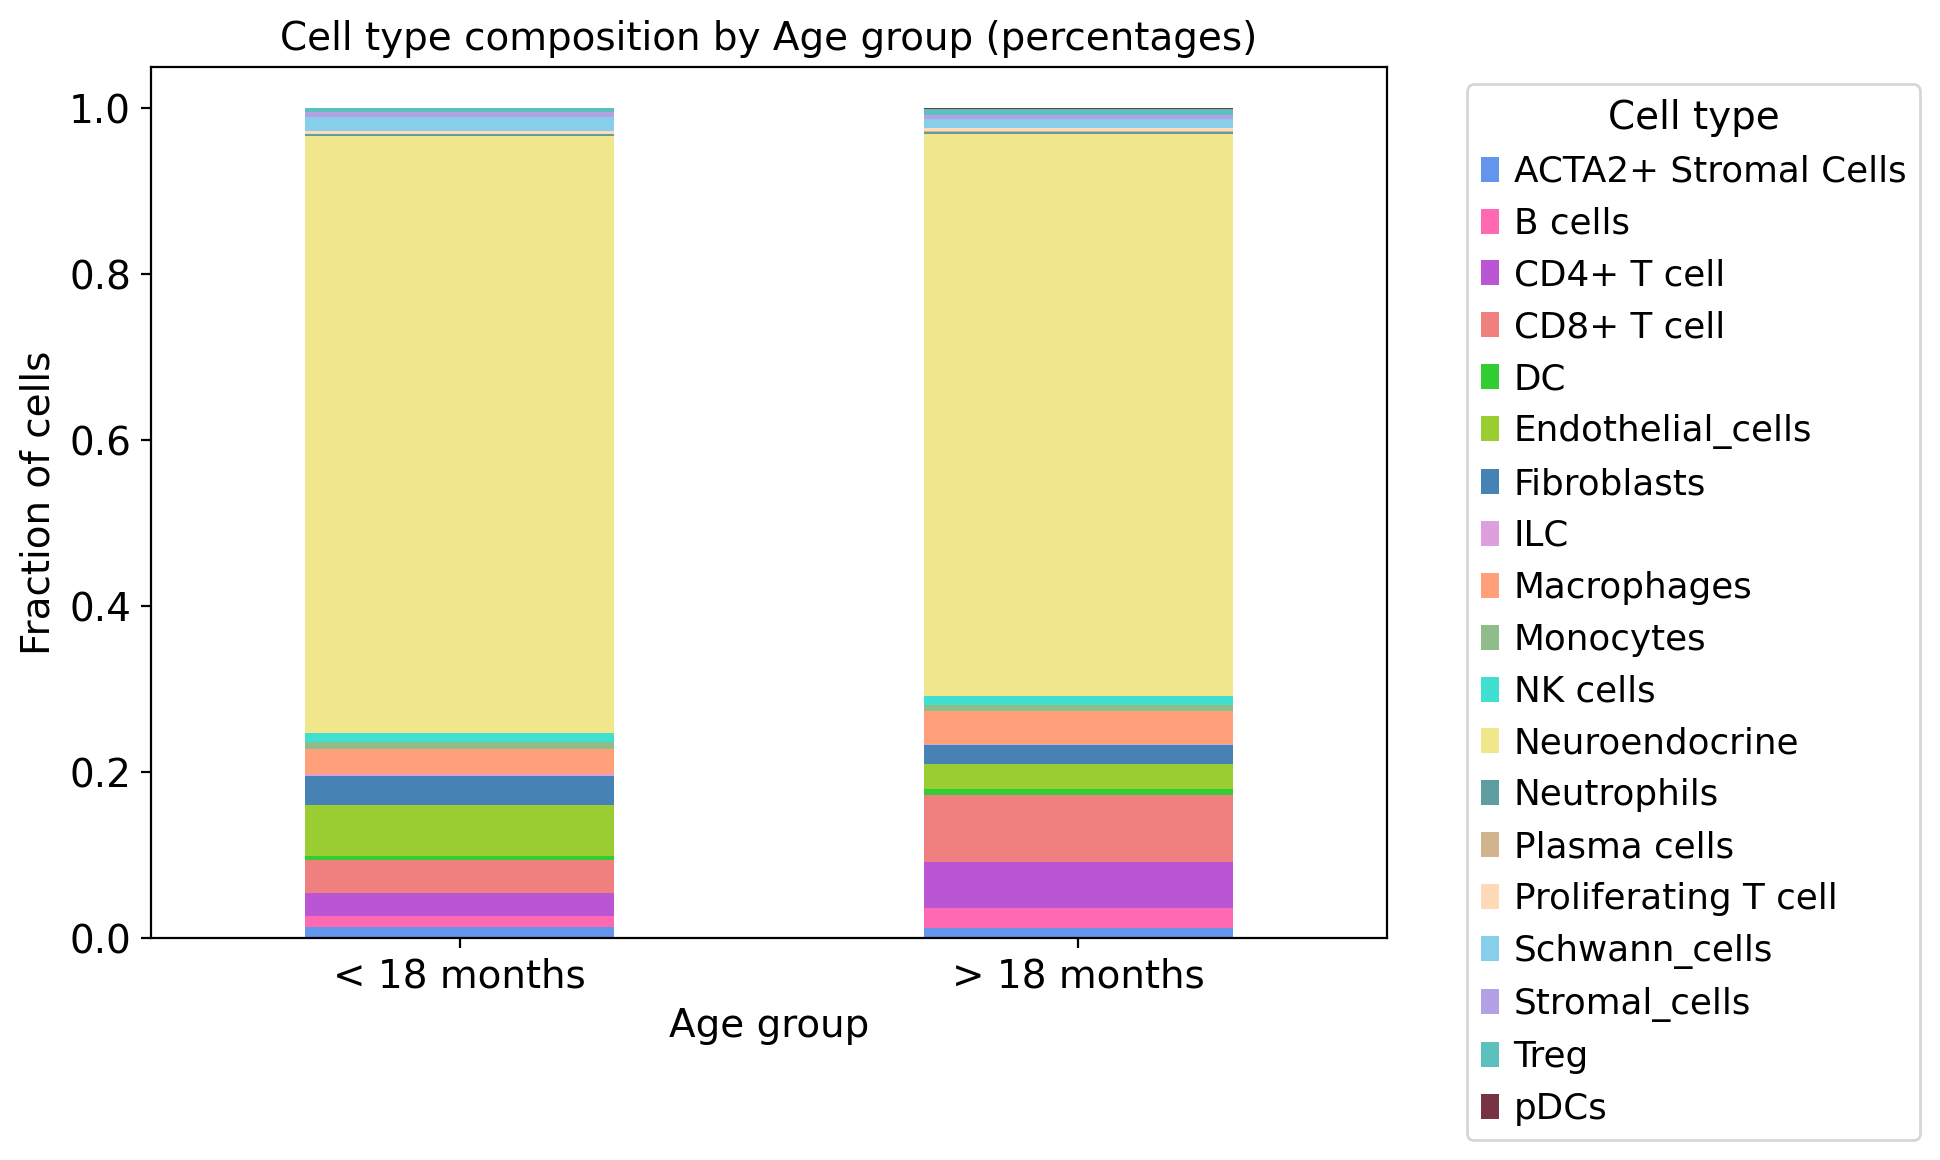

In [6]:
# Step 1: Group by Age and Cell Type, reshape to wide format
df = query.obs.groupby(["Age", "Final_Annotation"]).size().unstack(fill_value=0)

# Step 2: Normalize each row to get percentages
df_percent = df.div(df.sum(axis=1), axis=0)

# Optional: sort columns for consistency
df_percent = df_percent[sorted(df_percent.columns)]

# Check color list is long enough
if len(my_colors) < len(df_percent.columns):
    raise ValueError("Not enough colors for the number of cell types.")

# Step 4: Plot
df_percent.plot(
    kind="bar",
    stacked=True,
    color=my_colors[:len(df_percent.columns)],
    figsize=(10, 6)
)

plt.title("Cell type composition by Age group (percentages)")
plt.ylabel("Fraction of cells")
plt.xlabel("Age group")
plt.xticks(rotation=0)
plt.grid(False)
plt.legend(title="Cell type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## DAA

In [7]:
import pertpy as pt
import sccoda

In [8]:
query.obs['Study_method'] = query.obs['Study_method'].astype('category')

In [10]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    query[query.obs["method"] == "sc"].copy(),
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="Annotation",
    sample_identifier="SampleID",
    covariate_obs=["Age", "Study"],
)
sccoda_data

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 169764 × 5007
  2 modalities
    rna:	169717 x 5000
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'SampleID', 'percent_mito', 'percent_ribo', 'complexity', 'scDblFinder.class', 'DoubletFinder.class', 'singlet', 'nCount_tmp', 'nFeature_tmp', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'celltype_humatlas_main', 'celltype_humatlas_fine', 'Immune_UCell', 'Lymphoid_UCell', 'PanBcell_UCell', 'Bcell_UCell', 'APC_UCell', 'Epithelial_UCell', 'Stromal_UCell', 'Myeloid_UCell', 'MoMacDC_UCell', 'Neutrophils_UCell', 'Tcell_UCell', 'NK_UCell', 'Endothelial_UCell', 'Talphabeta_UCell', 'Plasma_cell_UCell', 'CD4Tcell_UCell', 'Treg_UCell', 'CD8T_UCell', 'Tgammadelta_UCell', 'TAM_UCell', 'Tgd1_UCell', 'Tgd2_UCell', 'CD4T_UCell', 'Fibroblast_UCell', 'Alveolar_type1_UCell', 'Alveolar_type2_UCell', 'Keratinocyte_UCell', 'Melanocyte_UCell', 'Macrophage_UCell', 'Mast_UCell', 'pDC_UCell', 'cDC1_UCell', 'cDC2_UCell', 'cDC2b_UCell', 'DC3_UCell', 'Monocyte_UCell', 'Monocyte_not_cDC2_UCell', 'is.pure_Bcell', 'is.pure_CD4T', 'is.pure_CD8T', 'is.pure_Endothelial', 'is.pure_Epithelial', 'is.pure_Fibroblast', 'is.pure_Macrophage', 'is.pure_Mast', 'is.pure_Monocyte', 'is.pure_Neutrophils', 'is.pure_NK', 'is.pure_panDC', 'is.pure_PlasmaCell', 'scGate_multi', 'CellOntology_name', 'CellOntology_ID', 'celltype_humatlas_main_filt', 'RNA_snn_res.1.5', 'seurat_clusters', 'singler_labels_raw', 'singler_labels', 'immune_cells', 'stromal_cells', 'endothelial_cells', 't_cells', 'b_cells', 'myeloid_cells', 'malignant_cells', 'final_annotation', 'Study', 'RNA_snn_res.0.1', 'Annotation', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.5', 'RNA_snn_res.0.6', 'RNA_snn_res.0.7', 'SingleR_NBatlas', 'SingleR_NBatlas_deep', 'less18M', 'Sex', 'MYCN_status', 'method', 'Deep_SingleR', 'Deep_scGate', 'Deep_Final', 'Study_method', 'Deep_Sample_Final', 'Deep_Sample_scGate', 'Deep_Sample_SingleR', 'Deep_Study_Final', 'Deep_Study_scGate', 'Deep_Study_SingleR', '_scvi_batch', '_scvi_labels', 'leiden_scVI_res1', 'leiden_scVI_res1.5', 'leiden_scVI_res2', 'leiden_scVI_res3', 'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine', 'manual_celltype_annotation', 'Final_Annotation', 'Age', 'scCODA_sample_id'
      var:	'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'Final_Annotation_colors', 'Sex_colors', 'Study_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_fine_colors', 'dea_leiden_1', 'dea_leiden_1_filtered', 'dendrogram_leiden_scVI_res1', 'hvg', 'leiden_scVI_res1', 'leiden_scVI_res1.5', 'leiden_scVI_res1.5_colors', 'leiden_scVI_res1_colors', 'leiden_scVI_res2', 'leiden_scVI_res2_colors', 'leiden_scVI_res3', 'leiden_scVI_res3_colors', 'log1p', 'manual_celltype_annotation_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_harmony', 'X_pca', 'X_scVI', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'scvi_normalized'
      obsp:	'connectivities', 'distances'
    coda:	47 x 7
      obs:	'SampleID', 'Age', 'Study'
      var:	'n_cells'

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/pertpy/tools/_coda/_base_coda.py:1678: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types, rotation=90)


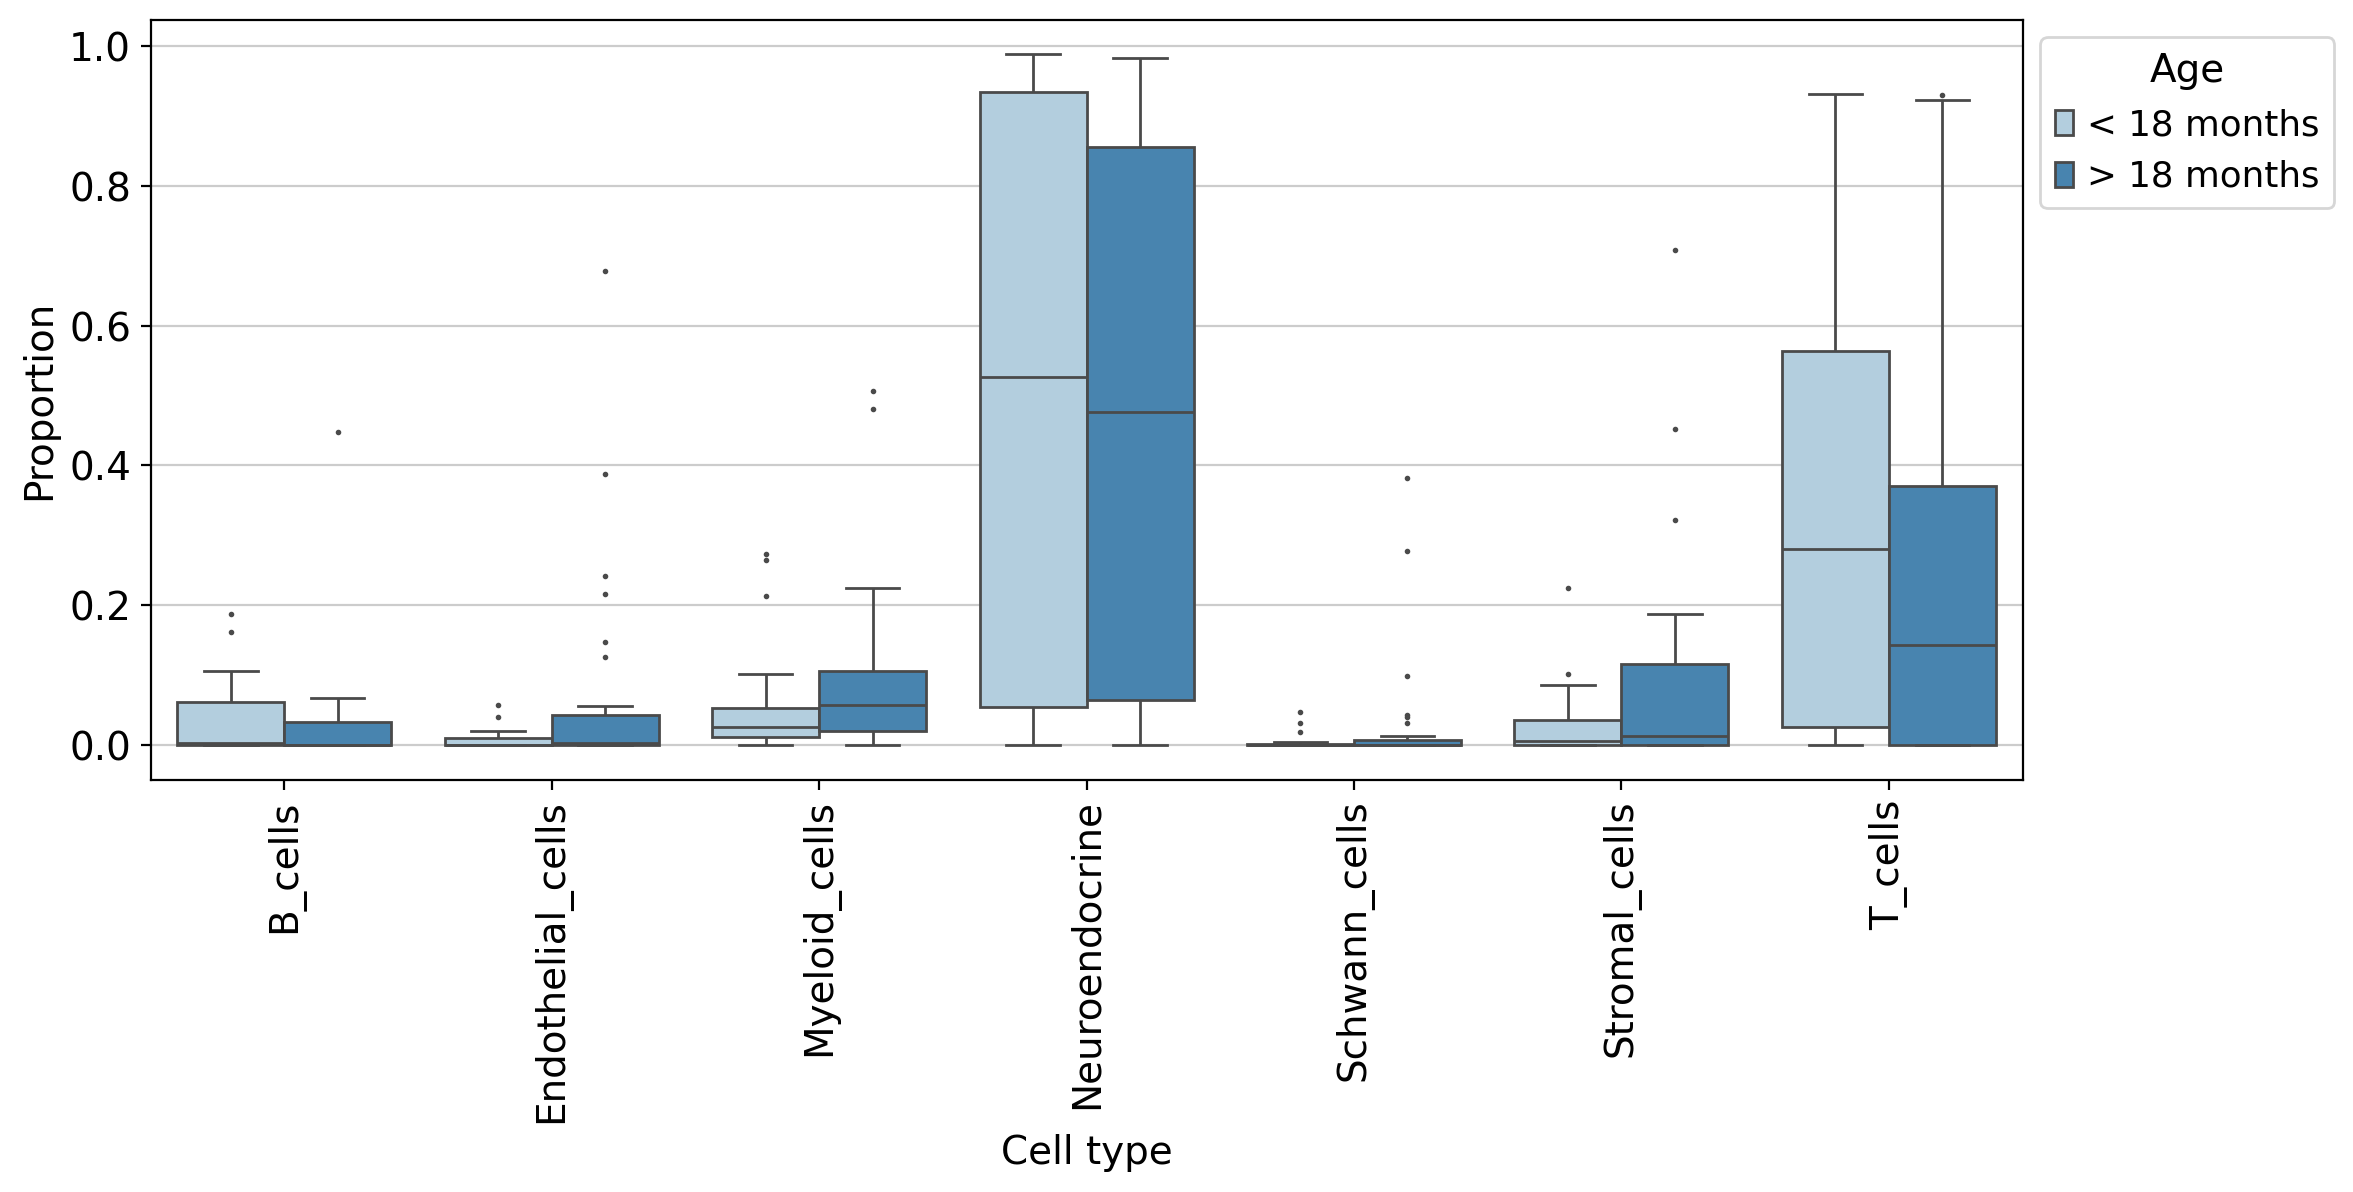

In [11]:
sccoda_model.plot_boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="Age",
    figsize=(12, 5)
)
plt.show()

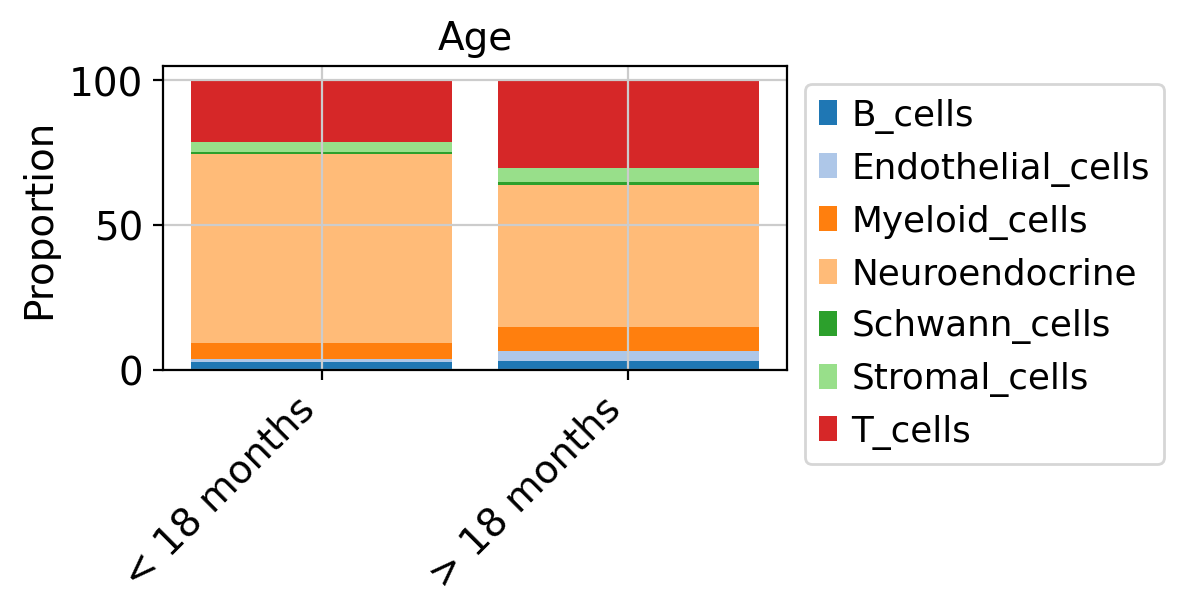

In [12]:
sccoda_model.plot_stacked_barplot(
    sccoda_data, modality_key="coda", feature_name="Age", figsize=(4, 2)
)
plt.show()

In [13]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="Age + Study",
    reference_cell_type="automatic",
    automatic_reference_absence_threshold=0.1
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=1234)

• Automatic reference selection! Reference cell type set to Myeloid_cells
• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|███████████████████████████████████████████████████████████████████| 11000/11000 [08:24<00:00, 21.81it/s, 255 steps of size 1.15e-02. acc. prob=0.89]


In [14]:
sccoda_model.summary(sccoda_data)

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/pertpy/tools/_coda/_base_coda.py:840: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  effect_df.index.levels[0].str.replace("Condition", "").str.replace("[", "").str.replace("]", ""),
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/pertpy/tools/_coda/_base_coda.py:840: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  effect_df.index.levels[0].str.replace("Condition", "").str.replace("[", "").str.replace("]", ""),


                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 47 samples, 7 cell types                                    │
│ Reference cell type                         │ Myeloid_cells                                                     │
│ Formula                                     │ Age + Study                                                       │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                    Final Parameter  Expected Sample                                                             │
│ Cell Type                                                                                                       │
│ B_cells                -1.433           302.411                                                                 │
│ Endothelial_cells      -1.513           279.161                                                                 │
│ Myeloid_cells          -0.628           676.402                                                                 │
│ Neuroendocrine         -0.922           504.107                                                                 │
│ Schwann_cells          -1.727           225.380                                                                 │
│ Stromal_cells          -1.284           351.001                                                                 │
│ T_cells                 0.005          1273.836                                                                 │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                     Final Parameter  Expected Sample  log2-fold change                          │
│ Covariate        Cell Type                                                                                      │
│ AgeT.> 18 months B_cells                 0.000           302.411            0.000                               │
│                  Endothelial_cells       0.000           279.161            0.000                               │
│                  Myeloid_cells           0.000           676.402            0.000                               │
│                  Neuroendocrine          0.000           504.107            0.000                               │
│                  Schwann_cells           0.000           225.380            0.000                               │
│                  Stromal_cells           0.000           351.001            0.000                               │
│                  T_cells                 0.000          1273.836            0.000                               │
│ StudyT.dong      B_cells                 0.000            83.886           -1.850                               │
│                  Endothelial_cells       0.000            77.436           -1.850                               │
│                  Myeloid_cells           0.000           187.627           -1.850                               │
│                  Neuroendocrine          3.075          3028.857            2.587                               │
│                  Schwann_cells           0.000            62.518           -1.850                               │
│                  Stromal_cells           0.000            97.364           -1.850                               │
│                  T_cells                -1.555            74.611           -4.094                               │
│ StudyT.patel     B_cells                 0.000            25.089           -3.591                               │
│                  Endothelial_cells       0.000            23.160           -3.591                               │
│                  Myeloid_cells           0.000            56.117           -3.591                               │
│                  Neuroendocrine          4.385          3354.432            2.734                               │
│                  Schwann_cells           0.000            18.698           -3.591                               │
│                  Stromal_cells           0.000            29.120           -3.591                               │
│                  T_cells                 0.000           105.682           -3.591                               │
│ StudyT.verhoeven B_cells                 0.000           302.411            0.000                               │
│                  Endothelial_cells       0.000           279.161            0.000                               │
│                  Myeloid_cells           0.000           676.402            0.000                               │
│                  Neuroendocrine          0.000           504.107            0.000                               │
│                  Schwann_cells           0.000           225.380            0.000                               │
│                  Stromal_cells           0.000           351.001            0.000                               │
│                  T_cells                 0.000          1273.836            0.000                               │
│ StudyT.wienke    B_cells                 0.000           219.926           -0.459                               │
│                  Endothelial_cells       0.000        

In [15]:
results_df

NameError: name 'results_df' is not defined

In [69]:
query.obs['Final_Annotation']

Tumor_10_dong_Tumor_10_dong_AAACCTGTCTTTAGTC.1                  Neuroendocrine
Tumor_10_dong_Tumor_10_dong_AAACGGGGTTTCCACC.1                  Neuroendocrine
Tumor_10_dong_Tumor_10_dong_AAAGATGCAGAGTGTG.1                  Neuroendocrine
Tumor_10_dong_Tumor_10_dong_AAAGATGGTACTTCTT.1                  Neuroendocrine
Tumor_10_dong_Tumor_10_dong_AAAGCAAAGAGCTTCT.1                  Neuroendocrine
                                                                     ...      
HTAPP_204_patel_rep1_HTAPP_204_patel_rep1_TTTGTCATCCAGTATG-1    Neuroendocrine
HTAPP_204_patel_rep1_HTAPP_204_patel_rep1_TTTGTCATCCCTAACC-1    Neuroendocrine
HTAPP_204_patel_rep1_HTAPP_204_patel_rep1_TTTGTCATCCTTGCCA-1    Neuroendocrine
HTAPP_204_patel_rep1_HTAPP_204_patel_rep1_TTTGTCATCTATGTGG-1    Neuroendocrine
HTAPP_204_patel_rep1_HTAPP_204_patel_rep1_TTTGTCATCTGATACG-1    Neuroendocrine
Name: Final_Annotation, Length: 452997, dtype: category
Categories (19, object): ['ACTA2+ Stromal Cells', 'B cells', 'CD4+ T cell',

In [16]:
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

In [17]:
import pandas as pd
import numpy as np
import scanpy as sc
from sccoda.util import comp_ana as mod

# Step 1: Aggregate counts per sample × cell type
counts_df = (
    query[query.obs["method"] == "sc"].copy().obs.groupby(["SampleID", "Annotation"])
    .size()
    .unstack(fill_value=0)
)

# Step 2: Build new AnnData
adata_counts = sc.AnnData(X=counts_df.values)

# Step 3: Add covariates to .obs
adata_counts.obs = query[query.obs["method"] == "sc"].copy().obs.drop_duplicates("SampleID").set_index("SampleID").loc[counts_df.index][["Age", "Study"]]

# Step 4: Add cell type names to .var
adata_counts.var_names = counts_df.columns
adata_counts.obs_names = counts_df.index

# Optional: make sure categorical variables are treated correctly
adata_counts.obs["Age"] = adata_counts.obs["Age"].astype("category")
adata_counts.obs["Study"] = adata_counts.obs["Study"].astype("category")

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:750: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['HTAPP_164_patel', 'HTAPP_312_patel', 'HTAPP_931_patel', 'M017AAB_T1_wienke', 'M124AAA_T_wienke']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:845: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['B_cells', 'Endothelial_cells', 'Myeloid_cells', 'Neuroendocrine', 'Schwann_cells']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:822: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['HTAPP_164_patel', 'HTAPP_312_patel', 'HTAPP_931_patel', 'M017AAB_T1_wienke', 'M124AAA_T_wienke']

    Inferred to

In [18]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # ⛔ disables GPU

In [19]:
# Step 5: Loop over each cell type as reference
cell_types = adata_counts.var_names.tolist()
results_cycle = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

In [20]:


for ct in cell_types:
    print(f"Reference: {ct}")
    
    model_temp = mod.CompositionalAnalysis(
        adata_counts.copy(),
        formula="Age + Study",
        reference_cell_type=ct
    )
    
    temp_results = model_temp.sample_hmc(num_results=20000)

    # Filter only Age-related effects
    cred_eff = temp_results.credible_effects()
    print(cred_eff)
    cred_eff = cred_eff.loc[cred_eff.index.get_level_values("Covariate") == "Age"]
    cred_eff.index = cred_eff.index.droplevel("Covariate")

    print(cred_eff)
    results_cycle["times_credible"] += cred_eff.astype(int)

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2025-04-22 11:55:08.072650: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Reference: B_cells
Zero counts encountered in data! Added a pseudocount of 0.5.


  0%|                                                                                                                                   | 0/20000 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1745312110.643512 3983884 service.cc:152] XLA service 0x7eec30aa4fa0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745312110.643573 3983884 service.cc:160]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1745312111.854446 3983884 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:01<00:00, 82.71it/s]


MCMC sampling finished. (307.832 sec)
Acceptance rate: 61.1%
Covariate           Cell Type        
Age[T.> 18 months]  B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine       False
                    Schwann_cells        False
                    Stromal_cells        False
                    T_cells              False
Study[T.dong]       B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine        True
                    Schwann_cells        False
                    Stromal_cells        False
                    T_cells               True
Study[T.patel]      B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine        True
                    Schwann_cells        False
        

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:16<00:00, 78.05it/s]


MCMC sampling finished. (323.623 sec)
Acceptance rate: 46.4%
Covariate           Cell Type        
Age[T.> 18 months]  B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine       False
                    Schwann_cells        False
                    Stromal_cells        False
                    T_cells              False
Study[T.dong]       B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine        True
                    Schwann_cells        False
                    Stromal_cells        False
                    T_cells               True
Study[T.patel]      B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine        True
                    Schwann_cells        False
        

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:18<00:00, 77.37it/s]


MCMC sampling finished. (326.349 sec)
Acceptance rate: 47.1%
Covariate           Cell Type        
Age[T.> 18 months]  B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine       False
                    Schwann_cells        False
                    Stromal_cells        False
                    T_cells              False
Study[T.dong]       B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine        True
                    Schwann_cells        False
                    Stromal_cells        False
                    T_cells               True
Study[T.patel]      B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine        True
                    Schwann_cells        False
        

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:03<00:00, 82.02it/s]


MCMC sampling finished. (306.652 sec)
Acceptance rate: 42.8%
Covariate           Cell Type        
Age[T.> 18 months]  B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine       False
                    Schwann_cells        False
                    Stromal_cells        False
                    T_cells              False
Study[T.dong]       B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine       False
                    Schwann_cells        False
                    Stromal_cells        False
                    T_cells               True
Study[T.patel]      B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine       False
                    Schwann_cells        False
        

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:16<00:00, 77.95it/s]


MCMC sampling finished. (323.405 sec)
Acceptance rate: 66.4%
Covariate           Cell Type        
Age[T.> 18 months]  B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine       False
                    Schwann_cells        False
                    Stromal_cells        False
                    T_cells              False
Study[T.dong]       B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine        True
                    Schwann_cells        False
                    Stromal_cells        False
                    T_cells               True
Study[T.patel]      B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine        True
                    Schwann_cells        False
        

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:21<00:00, 76.46it/s]


MCMC sampling finished. (332.306 sec)
Acceptance rate: 55.7%
Covariate           Cell Type        
Age[T.> 18 months]  B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine       False
                    Schwann_cells        False
                    Stromal_cells        False
                    T_cells              False
Study[T.dong]       B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine        True
                    Schwann_cells        False
                    Stromal_cells        False
                    T_cells               True
Study[T.patel]      B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine        True
                    Schwann_cells        False
        

/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/bigdata/katepetrenko/miniconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:23<00:00, 75.96it/s]


MCMC sampling finished. (332.405 sec)
Acceptance rate: 48.3%
Covariate           Cell Type        
Age[T.> 18 months]  B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine       False
                    Schwann_cells        False
                    Stromal_cells        False
                    T_cells              False
Study[T.dong]       B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine        True
                    Schwann_cells        False
                    Stromal_cells        False
                    T_cells              False
Study[T.patel]      B_cells              False
                    Endothelial_cells    False
                    Myeloid_cells        False
                    Neuroendocrine        True
                    Schwann_cells        False
        

In [24]:
# Final scoring
results_cycle["pct_credible"] = results_cycle["times_credible"] / len(cell_types)
results_cycle["is_credible"] = results_cycle["pct_credible"] > 0.5

print(results_cycle.sort_values("pct_credible", ascending=False))

                   times_credible  pct_credible  is_credible
B_cells                       NaN           NaN        False
Endothelial_cells             NaN           NaN        False
Myeloid_cells                 NaN           NaN        False
Neuroendocrine                NaN           NaN        False
Schwann_cells                 NaN           NaN        False
Stromal_cells                 NaN           NaN        False
T_cells                       NaN           NaN        False


In [25]:
print(results_cycle.sort_values("pct_credible", ascending=False))

                   times_credible  pct_credible  is_credible
B_cells                       NaN           NaN        False
Endothelial_cells             NaN           NaN        False
Myeloid_cells                 NaN           NaN        False
Neuroendocrine                NaN           NaN        False
Schwann_cells                 NaN           NaN        False
Stromal_cells                 NaN           NaN        False
T_cells                       NaN           NaN        False


In [23]:
results_cycle

,times_credible,pct_credible,is_credible
B_cells,NaN,NaN,False
Endothelial_cells,NaN,NaN,False
Myeloid_cells,NaN,NaN,False
Neuroendocrine,NaN,NaN,False
Schwann_cells,NaN,NaN,False
Stromal_cells,NaN,NaN,False
T_cells,NaN,NaN,False
